In [1]:
import os

In [9]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configures matplotlib to inline and will display graphs below the corresponding cell
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

#for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

#manipulation of zipped images and getting numpy arrays of pixel values of images
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image


In [10]:
X = []
Z = []
IMG_SIZE = 150
FLOWER_SUNFLOWER_DIR = '../BeeSnap-ML/flowers/sunflower'

In [12]:
def assign_label(img,flower_type):
    return flower_type

In [13]:
def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        

In [15]:
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:01<00:00, 506.25it/s]

1468


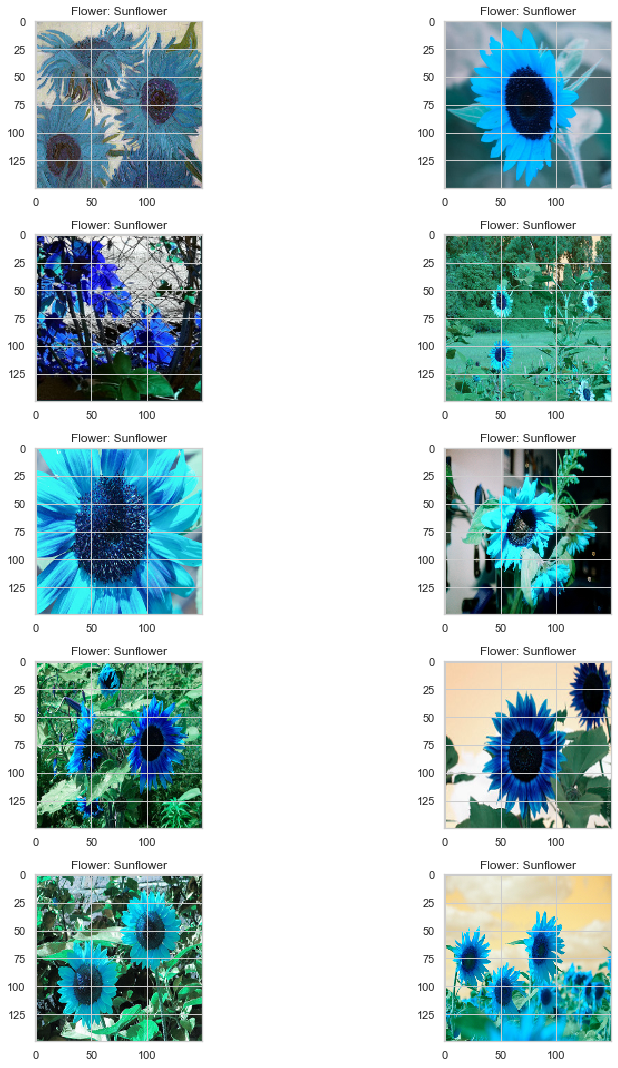

In [27]:
#visualize 10 images
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
l=1000
for i in range(5):
    for j in range(2):
        ax[i, j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        l = l + 1
plt.tight_layout()
